루브릭

1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.

모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.

regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.

3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.

Accuracy 기준 85%에 도달하였다.

# E-09 폐렴아 기다려라.
***
목차


Step 1. 실험환경 Set-up

Batch size, Epoch 등을 변경.

In [2]:
# 사용할 패키지
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 변수 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


Step 2. 데이터 준비하기

원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않다.
의료데이터는 작은 변화에 민감하기 때문에 좌우 반전 정도만 진행하자.

In [29]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Normal images count in training set: 1072
Pneumonia images count in training set: 3113
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  False


In [15]:
#테스트 데이터 동일하게 진행
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인.
augmentation을 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

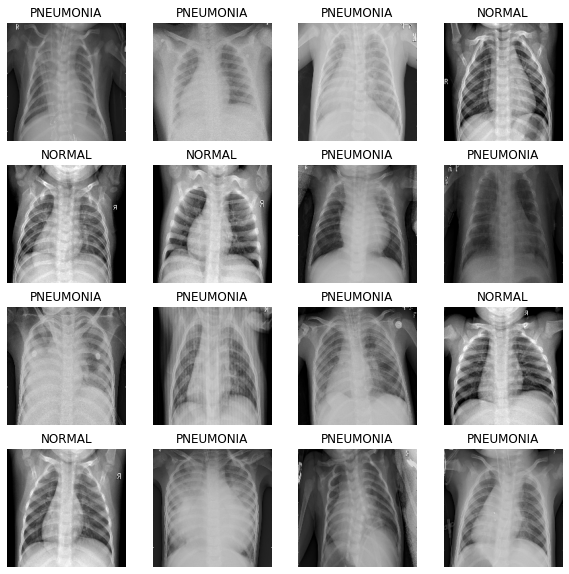

In [7]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

- **사진 자세히 보면 오른쪽을 나타내는 R 글자가 뒤집 사진이 섞여 있는 것을 볼수 있다.**
- 데이터증강이 잘 처리 되었다.

Step 4. CNN 모델링
- 하이퍼파라미터 조정. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.
- BatchNormalization 여부 조정
- Dropout 비율 조정
- 상기 두가지는 데이터가 부족한 의료 영상에서 실용적으로 간혹 좋은 성능을 보이기도 한다.

In [8]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# dense block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [9]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

Step 5. 데이터 imbalance 처리

실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [10]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [28]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [29]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 85s 190ms/step - loss: 0.4515 - accuracy: 0.7689 - precision: 0.9400 - recall: 0.7362 - val_loss: 0.6672 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2423 - accuracy: 0.8994 - precision: 0.9719 - recall: 0.8906 - val_loss: 1.5241 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2155 - accuracy: 0.9183 - precision: 0.9711 - recall: 0.9176 - val_loss: 0.0998 - val_accuracy: 0.9625 - val_precision: 0.9879 - val_recall: 0.9607
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1992 - accuracy: 0.9289 - precision: 0.9766 - recall: 0.9266 - val_loss: 0.1093 - val_accuracy: 0.9644 - val_precision: 0.9752 - val_recall: 0.9765
Epoch 5/25
261/261 [==============================] - 53s 202ms/step - loss: 0.1899 - accura

Step 7. 결과 확인과 시각화

의료 영상 모델의 특성상 recall이 중요하다.
훈련과정의 history 그래프를 시각화해 보고, 분석해보자.

39/39 [==============================] - 4s 104ms/step - loss: 0.9283 - accuracy: 0.8173 - precision: 0.7828 - recall: 0.9795
Loss: 0.9283486604690552,
Accuracy: 0.817307710647583,
Precision: 0.7827869057655334,
Recall: 0.9794871807098389


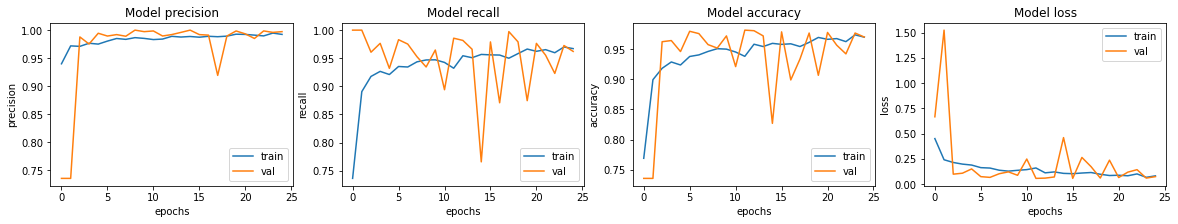

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

### 분석_좌우 대칭 데이터 추가한 모델.
학습 분석
- 훈련과 검증셋의 acc 와 loss 가 꾸준히 증가, 감소 하여 수렴하는 양상으로 과적합은 나타나지 않았다.
- precision은 안정적인데 반해 recall은 0.8~1.0 사이를 튀며 학습이 진행 되었다.

기존 좌우대칭 데이터가 없는 모델
> Loss: 1.4594850540161133,  
Accuracy: 0.7339743375778198,  
Precision: 0.701438844203949,  
Recall: 1.0

좌우대칭 데이터로 증강한 모델
>Loss: 0.9283486604690552,  
Accuracy: 0.817307710647583,  
Precision: 0.7827869057655334,  
Recall: 0.9794871807098389

분석
- accuracy, precision 모두 개선 되었다. 특히 acc 는 0.08 가량 증가 하였다.
- 양성 판별중 실제 양성 비율을 나타내는 precision도 증가하였다.
- 실제 양성중 양성비율을 나타내는 recall 은 소폭 감소 하였지만 성능에 문제가 있을 정도는 아니다.

회고

알게된 점
- 좌우대칭 데이터 증강 만으로 0.73에서 0.81로 선능이 개선된것이 놀랍다.

아쉬운 점
- 뿌연 부분 에서 폐렴을 판단한다고 하니 밝기를 기준으로 특정 범위만 전처리 하는 것을 시도해보았다면 좋았을 것이다.
- 전이 학습으로 vgg16 모델을 사용하면 어떻게 될지 궁금하였지만, 시도하지 못했다.